<h2 style = "color: chocolate">Tarea N°2</h2>

---

Ayudante: Diego Bernal

La tragedia del naufragio del Titanic es uno de los naufragios más famosos de la historia.
El 15 de abril de 1912, durante su viaje inaugural, el RMS Titanic, considerado ampliamente “inafundable”,
se hundió después de chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas
para todos a bordo, lo que resultó en la muerte de 1502 de los 2224 pasajeros y tripulantes.
Aunque había cierto elemento de suerte involucrado en la supervivencia, parece que ciertos grupos de
personas tenían más probabilidades de sobrevivir que otros.
En este ejercicio, se solicita que construyas un modelo predictivo que responda a la pregunta: ¿Qué tipo de
personas tenían más probabilidades de sobrevivir? Utilizando datos de los pasajeros (como edad, género,
clase socioeconómica, etc.). El conjunto de datos está organizado de la siguiente manera:

## Descripción de las variables

| Variable            | Descripción                                 |
|---------------------|----------------------------------------------|
| Clase del pasajero               | Variable Categorica que hace referencia a la clase que adquirio el pasajero (1 = 1st, 2 = 2nd, 3 = 3rd)             |
| Indicador de supervivencia             | Variable binaria que indica la supervivencia del psajero (0 = No, 1 = Yes)                 |
| sexo               | Variable binaria que indoca el género del pasajero                          |
| Edad                 | Variable continua indica la edad del pasajero                             |
| N° de hermanos y conyugues       | Variable discreta que representa la cantidad de hermano o conyugues       |
| N° de padres e hijos a bordo           | Variable discreta que representa la cantidad de padres e hijos                          |
| Tarifa pagada en Libras           | Variable continua que representa la tarifa que pago el pasajero                          |
| Embarcado-Puerto de embarque           |Variable categorica que indica el puerto donde el pasajero abordo, (C = Cherbourg, Q = Queenstown, S = Southampton)                             |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.formats.style import Styler
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,RocCurveDisplay,ConfusionMatrixDisplay,roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("./data/titanic_data.csv")

In [3]:
#Se define una función a la cual se le entrega como argumentos un df y un titulo 
def show(df, title): 
    filas, cols = df.shape  #se declaran las variables con la cantidad de filas y columnas del df original graciasa .shape
    filas_selec = df.iloc[[0, 1, 2, -3, -2, -1]] #se genera un df con las 3 primeras filas y las 3 ultimas
    caption = f"{title}<br>Shape: {filas} Filas × {cols} Columnas.<br> " #se crea el titulo con lo solicitado
    display(filas_selec.style.set_caption(caption)) #se le agrrega al df el titulo creado

In [4]:
show(df, "Titanic")

,x,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,3,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,"Montreal, PQ / Chesterville, ON"
1306,1307,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.225,?,C,?
1307,1308,3,0,"Zakarian, Mr. Ortin",male,27,0,0,2670,7.225,?,C,?
1308,1309,3,0,"Zimmerman, Mr. Leo",male,29,0,0,315082,7.875,?,S,?


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   survived              1043 non-null   int64  
 1   sex                   1043 non-null   int64  
 2   age                   1043 non-null   float64
 3   sibsp                 1043 non-null   int64  
 4   parch                 1043 non-null   int64  
 5   fare                  1043 non-null   float64
 6   pclass_Middle         1043 non-null   int64  
 7   pclass_Upper          1043 non-null   int64  
 8   embarked_Queenstown   1043 non-null   int64  
 9   embarked_Southampton  1043 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 89.6 KB


In [5]:
df = df.drop(columns=['home.dest','cabin','name','x','ticket'])

In [6]:
df['pclass'].value_counts()

pclass
3    709
1    323
2    277
Name: count, dtype: int64

In [7]:
df['pclass'] = df['pclass'].map({1: 'Upper', 2: 'Middle', 3: 'Lower'})

In [8]:
df = pd.get_dummies(df,columns=['pclass'],drop_first=True)

In [9]:
df['pclass_Middle'] = df['pclass_Middle'].astype(int) 
df['pclass_Upper'] = df['pclass_Upper'].astype(int) 

In [10]:
df = df.dropna()

In [11]:
df = df[df['embarked'] != '?']

In [12]:
df['embarked'] = df['embarked'].map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})

In [13]:
df = pd.get_dummies(df,columns=['embarked'],drop_first=True)

In [14]:
df['embarked_Queenstown'] = df['embarked_Queenstown'].astype(int) 
df['embarked_Southampton'] = df['embarked_Southampton'].astype(int) 

In [15]:
df = df[df['age'] != '?']
df = df[df['fare'] != '?']

In [16]:
df['age'] = df['age'].astype(float)
df['fare'] = df['fare'].astype(float) 

In [17]:
df['sex'] = df['sex'].map({'female': 0, 'male': 1})

In [18]:
show(df,'titanic')

,survived,sex,age,sibsp,parch,fare,pclass_Middle,pclass_Upper,embarked_Queenstown,embarked_Southampton
0,1,0,29.000000,0,0,211.337500,0,1,0,1
1,1,1,0.916700,1,2,151.550000,0,1,0,1
2,0,0,2.000000,1,2,151.550000,0,1,0,1
1306,0,1,26.500000,0,0,7.225000,0,0,0,0
1307,0,1,27.000000,0,0,7.225000,0,0,0,0
1308,0,1,29.000000,0,0,7.875000,0,0,0,1


In [19]:
columns = ['age','fare']

In [20]:
X = df.drop(df.columns[0], axis=1)
Y = df['survived']

## Estadistica Descriptiva

In [21]:
X_graf = X[columns]
X_graf.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1043.0,29.813199,14.366261,0.1667,21.00,28.00,39.0000,80.0000
fare,1043.0,36.603024,55.753648,0.0000,8.05,15.75,35.0771,512.3292


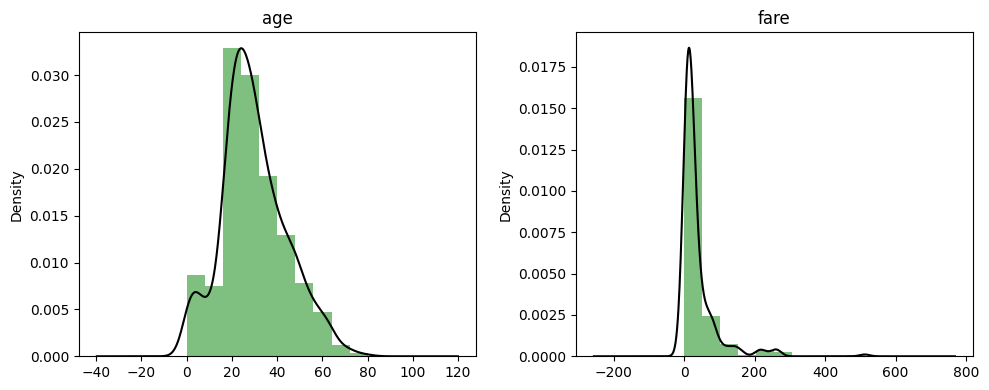

In [22]:
fig, axes = plt.subplots(1, len(X_graf.columns), figsize=(5 * len(X_graf.columns), 4)) #Se genera una figura con 1 fila con varios plots, se utiliza el largo de las cols para ajustar el ancho para que tengan mas  espacio
for i, col in enumerate(X_graf.columns):#Iterador que utiliza las columnas y su indice
    ax = axes[i]  # Declaramos ax para trabajar con el subplot correspondiente
    X_graf[col].plot(kind='hist', density=True,color="green", ax=ax, alpha=0.5) #Genera un hist para la variable col
    X_graf[col].plot(kind='kde', ax=ax, color='black') #Genra una distri de kernel para la variable col
    ax.set_title(col)#Establece el titulo para la variable col utilizandola

plt.tight_layout()
plt.show()
    

In [23]:
X_graf['survived'] = Y

C:\Users\Diego\AppData\Local\Temp\ipykernel_22252\3165181773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_graf['survived'] = Y


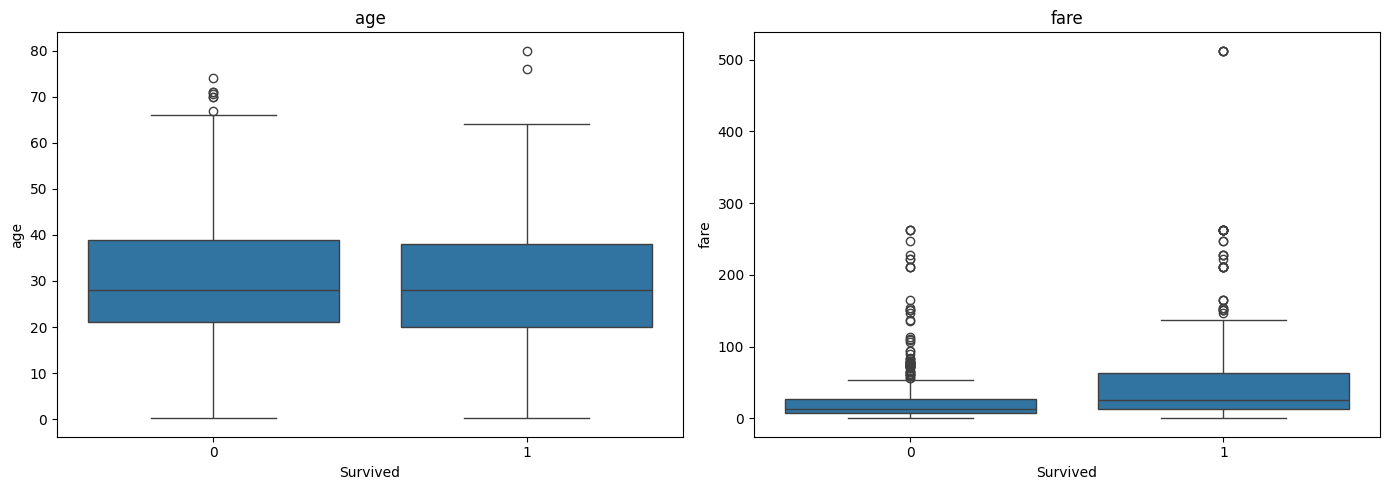

In [24]:
fig, axes = plt.subplots(1, len(X_graf.columns)-1, figsize=(5 * len(X_graf.columns)-1, 5)) #Se genera una figura con 1 fila de subplots de los cuales se generan segun las dim de 
for i, col in enumerate(X_graf.columns[:-1]): #Iterador a trav+es de ñas columnas del df que utiliza su indice como la columna
    ax = axes[i] # Declaramos ax para trabajar con el subplot correspondiente
    sns.boxplot(x='survived', y=col, data=X_graf, ax=ax) #utilizamos la biblioteca seaborn para generar los histogramas correspondientes
    ax.set_title(col) #Layers
    ax.set_xlabel('Survived'); ax.set_ylabel(col)

plt.tight_layout()
plt.show()
    

In [25]:
corr = X.corr()

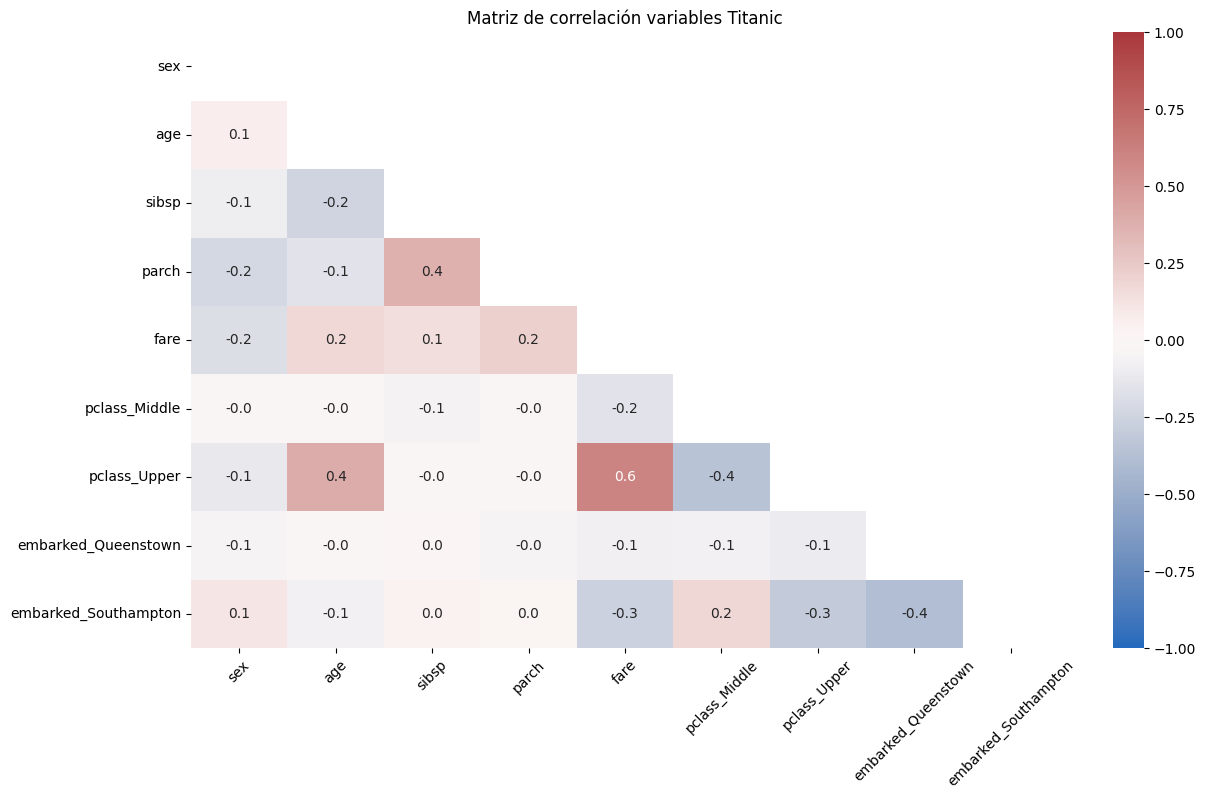

In [26]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='vlag', vmin=-1, vmax=1, fmt='.1f')

plt.title('Matriz de correlación variables Titanic')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Separación en Train y Test

In [27]:
columns

['age', 'fare']

In [28]:
scaler = StandardScaler()

In [29]:
X[columns] =  scaler.fit_transform(X[columns])

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,stratify = Y, test_size=0.2, random_state=707)

In [35]:
model = GaussianNB()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

In [36]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.73


In [40]:
classes = ["Not survived", "survived"]

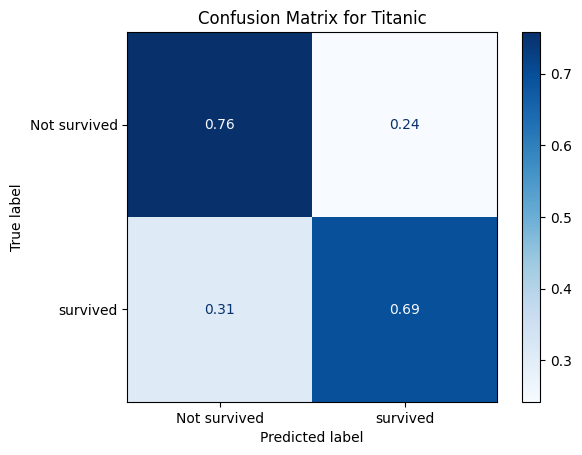

In [38]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic')
plt.grid(False)
plt.show()


<p>Modelo de analiis de discrimnante lineal y cuadratico</p>

In [39]:
model = LinearDiscriminantAnalysis()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

In [40]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.76


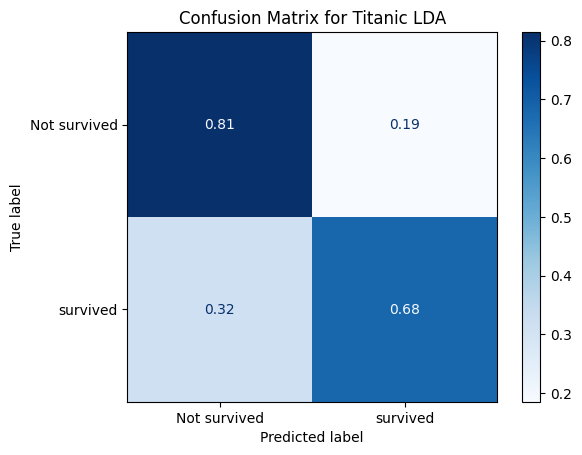

In [41]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic LDA')
plt.grid(False)
plt.show()


In [42]:
model = QuadraticDiscriminantAnalysis()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

In [43]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.72


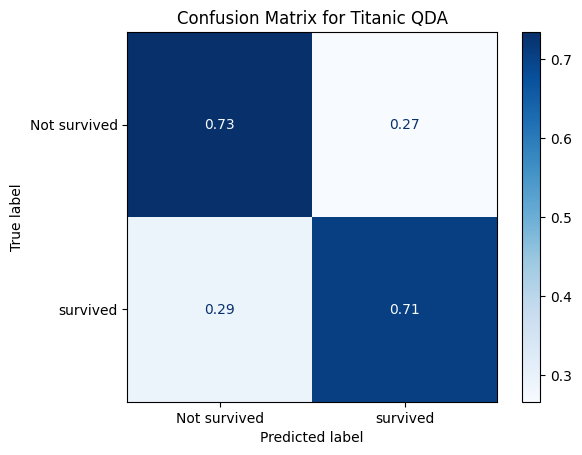

In [44]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic QDA')
plt.grid(False)
plt.show()


<p>Arboles de Desición, Random Forest y XGBoosting</p>

In [45]:
model = DecisionTreeClassifier(random_state=707)

In [47]:
param_dist = {
    'max_depth': [int(x) for x in np.linspace(10, 1000, 10)],
    'min_samples_split': [2, 5, 10, 14],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

In [48]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_dist,
    cv = 5,
    scoring='accuracy'
)

In [49]:
grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...dom_state=707)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [10, 120, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [50]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [51]:
best_model

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,14
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,707
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [52]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.74


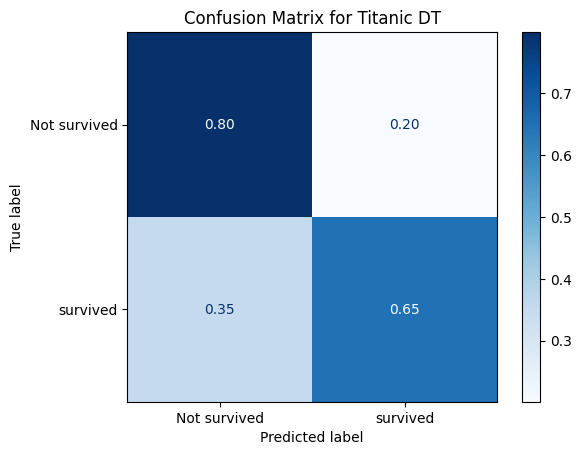

In [53]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic DT')
plt.grid(False)
plt.show()


In [54]:
model = RandomForestClassifier(random_state=707)

In [55]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(200, 2000, 10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 1000, 10)],
    'min_samples_split': [2, 5, 10, 14],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['entropy', 'gini']
}

In [56]:
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv = 5,
    scoring='accuracy'
)

In [157]:
grid_search.fit(X_train, Y_train)

,estimator,RandomForestC...dom_state=707)
,param_distributions,"{'criterion': ['entropy', 'gini'], 'max_depth': [10, 120, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,20
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [158]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [159]:
best_model

,n_estimators,600
,criterion,'entropy'
,max_depth,1000
,min_samples_split,5
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [162]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.78


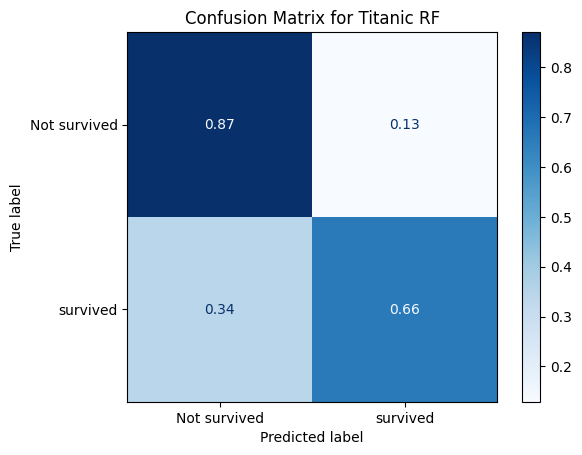

In [161]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic RF')
plt.grid(False)
plt.show()


In [57]:
model = GradientBoostingClassifier(random_state=42)

In [61]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [62]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10, 
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=707
)

In [63]:
random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,707
,error_score,nan


In [64]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [65]:
best_model

,loss,'log_loss'
,learning_rate,0.01
,n_estimators,600
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [66]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.79


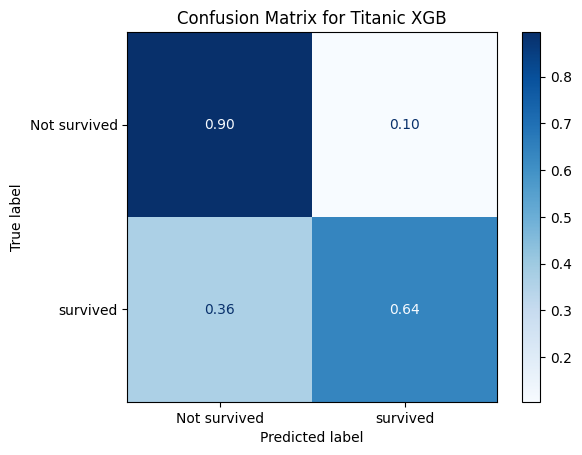

In [67]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic XGB')
plt.grid(False)
plt.show()


<p>SVM</p>

In [31]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [2, 3, 4, 5, 6, 7, 8]
C_values = [1, 3, 5, 6, 7]

In [ ]:
param_dist = {
    'kernel': kernels,
    'degree': degrees,
    'C': C_values,
}


In [ ]:
svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=param_dist, cv=5, scoring='accuracy')


grid_search.fit(X_train, Y_train)

,estimator,SVC(probability=True)
,param_grid,"{'C': [1, 3, ...], 'degree': [2, 3, ...], 'kernel': ['linear', 'poly', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,3


In [34]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [38]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)

print("Mejores parámetros:", best_params)
print("Precisión (accuracy) en datos de prueba:", accuracy)

Mejores parámetros: {'C': 3, 'degree': 2, 'kernel': 'rbf'}
Precisión (accuracy) en datos de prueba: 0.7799043062200957


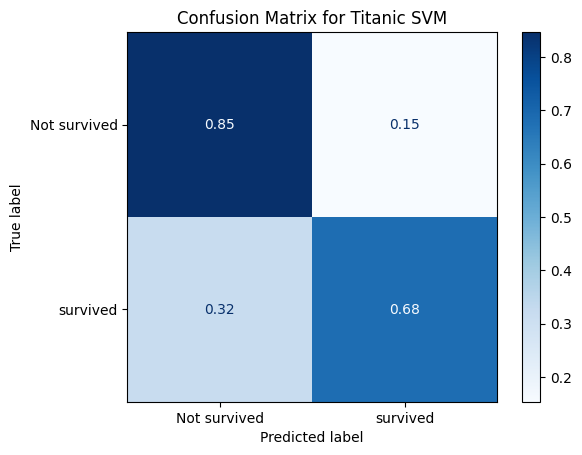

In [41]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic SVM')
plt.grid(False)
plt.show()

<p>MLP</p>

In [47]:
model = MLPClassifier()

In [51]:
param_dist = {
    "hidden_layer_sizes": [(1,),(50,),(100,),(100,50),(100,100),(100,100,50),(100,100,100,100)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],
}

In [52]:
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv = 5,
    scoring='accuracy'
)

In [53]:
grid_search.fit(X_train, Y_train)

c:\Users\Diego\OneDrive\Escritorio\Tarea_2_EMGV\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\OneDrive\Escritorio\Tarea_2_EMGV\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\OneDrive\Escritorio\Tarea_2_EMGV\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\OneDrive\Escritorio\Tarea_2_EMGV\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

,estimator,MLPClassifier()
,param_distributions,"{'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, ...], 'hidden_layer_sizes': [(1,), (50,), ...], 'solver': ['adam', 'lbfgs']}"
,n_iter,20
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [54]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [55]:
print("Accuracy:", round(accuracy_score(Y_test, y_pred),2))

Accuracy: 0.78


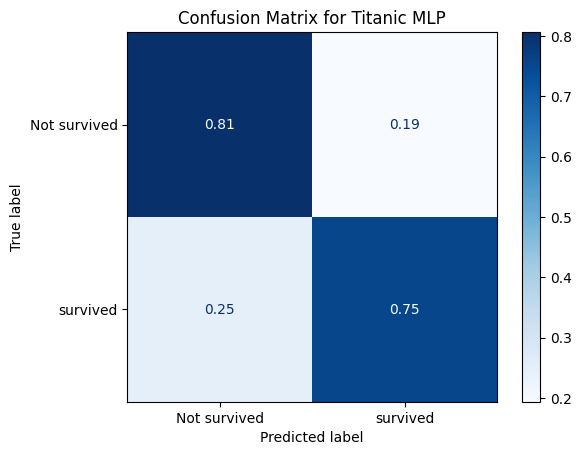

In [56]:
cnf_matrix = confusion_matrix(Y_test, y_pred, normalize='true')
np.set_printoptions(precision=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Titanic MLP')
plt.grid(False)
plt.show()